# [TR-003] Chew-Mandelstam

In [ ]:
%pip install -q ampform==0.10.1 matplotlib==3.4.2 mpl-interactions==0.17.12 numpy==1.21.0 qrules==0.9.0 scipy==1.7.0 sympy==1.8

<!-- cspell:ignore dasharray dashoffset displaystyle displaystyledisplaystyle  linecap linejoin xlink xtick ytick -->

This report is an attempt to visualize the Chew-Mandelstam function described in {pdg-review}`2020; Resonances; pp.9-10` (Section 49.3.5).

In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib widget
import os
import warnings

import matplotlib.pyplot as plt
import mpl_interactions.ipyplot as iplt
import numpy as np
import qrules
import scipy.integrate
import symplot
import sympy as sp
from ampform.dynamics import (
    BlattWeisskopfSquared,
    ComplexSqrt,
    breakup_momentum_squared,
    phase_space_factor,
    phase_space_factor_complex,
)
from IPython.display import Math

warnings.filterwarnings("ignore")
STATIC_WEB_PAGE = {"EXECUTE_NB", "READTHEDOCS"}.intersection(os.environ)
PDG = qrules.load_pdg()

## S-wave

As can be seen in Eq. (49.35), the Chew-Mandelstam function $\Sigma_a$ for a particle $a$ decaying to particles $1, 2$ has a simple form for angular momentum $L=0$ ($S$-wave). The only question is how to deal with negative values for the squared break-up momentum $q_a^2$. Here, we will use AmpForm's {class}`~ampform.sympy.math.ComplexSqrt`:

In [ ]:
q_squared_symbol = sp.Symbol("q_a^{2}", real=True)
q_a_expr = ComplexSqrt(q_squared_symbol)
Math(f"q_a = {sp.latex(q_a_expr)} = {sp.latex(q_a_expr.evaluate())}")

<IPython.core.display.Math object>

In [ ]:
def breakup_momentum(s, m1, m2):
    q_squared = breakup_momentum_squared(s, m1, m2)
    return ComplexSqrt(q_squared)

In [ ]:
phsp_scale_factor = 16 * sp.pi ** 2


def chew_mandelstam_s_wave(s, m1, m2):
    q = breakup_momentum(s, m1, m2)
    left_term = sp.Mul(
        2 * q / sp.sqrt(s),
        sp.log((m1 ** 2 + m2 ** 2 - s + 2 * sp.sqrt(s) * q) / (2 * m1 * m2)),
        evaluate=False,
    )
    right_term = m1 ** 2 - m2 ** 2
    right_term *= 1 / s - 1 / (m1 + m2) ** 2
    right_term *= sp.log(m1 / m2)
    return (left_term - right_term) / phsp_scale_factor

To check whether this implementation is correct, let's plug some {class}`~sympy.core.symbol.Symbol`s into this function and compare it to Eq. (49.35) on {pdg-review}`2020; Resonances; p.9`:

In [ ]:
s, m1, m2 = sp.symbols("s m1 m2", real=True)
chew_mandelstam_s_wave_expr = chew_mandelstam_s_wave(s, m1, m2)

In [ ]:
chew_mandelstam_s_wave_symbolic = chew_mandelstam_s_wave_expr.subs(
    2 * breakup_momentum(s, m1, m2),
    2 * sp.Symbol("q_a"),
)
chew_mandelstam_s_wave_symbolic *= phsp_scale_factor
sp.Mul(
    1 / phsp_scale_factor,
    chew_mandelstam_s_wave_symbolic,
    evaluate=False,
)

(1/(16*pi**2))*(2*q_a*log((m1**2 + m2**2 + 2*q_a*sqrt(s) - s)/(2*m1*m2))/sqrt(s) - (m1**2 - m2**2)*(-1/(m1 + m2)**2 + 1/s)*log(m1/m2))

It should be noted that this equation is not well-defined along the real axis, that is, for $\mathrm{Im}(s) = 0$. For this reason, we split $s$ into a real part $s'$ with a small imaginary offset (the PDG indicates this with $s+0i$). We parametrized this imaginary offset with $\epsilon$, and for the interactive plot, we do so with a power of $10$:

In [ ]:
epsilon = sp.Symbol("epsilon", real=True, positive=True)
s_prime = sp.Symbol(R"s^{\prime}", real=True)
s_plus = s_prime + sp.I * sp.Pow(10, -epsilon)

In [ ]:
Math(fR"{sp.latex(s)} \to {sp.latex(s_plus)}")

<IPython.core.display.Math object>

We are now ready to use [`mpl_interactions`](https://mpl-interactions.rtfd.io) and AmpForm's {mod}`symplot` to visualize this function:

In [ ]:
chew_mandelstam_s_wave_prime = chew_mandelstam_s_wave_expr.subs(s, s_plus)
np_chew_mandelstam_s_wave, sliders = symplot.prepare_sliders(
    expression=chew_mandelstam_s_wave_prime,
    plot_symbol=s_prime,
)
np_phase_space_factor = sp.lambdify(
    args=(s_prime, m1, m2, epsilon),
    expr=phase_space_factor_complex(s_plus, m1, m2),
    modules="numpy",
)

As starting values for the interactive plot, we assume $\pi\eta$ scattering (just like in the PDG section) and use their masses as values for $m_1$ and $m_1$, respectively.

In [ ]:
s_min, s_max = -0.15, 1.4
m1_val = PDG["pi0"].mass
m2_val = PDG["eta"].mass

plot_domain = np.linspace(s_min, s_max, 500)
sliders.set_ranges(
    m1=(0, 2, 200),
    m2=(0, 2, 200),
    epsilon=(1, 12),
)
sliders.set_values(
    m1=m1_val,
    m2=m2_val,
    epsilon=4,
)

For comparison, we plot the Chew-Mandelstam function for $S$-waves next to AmpForm's {class}`~ampform.dynamics.PhaseSpaceFactorComplex`. Have a look at the resulting plots and compare to Figure 49.3 on {pdg-review}`2020; Resonances; p.10`.

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 4.5), tight_layout=True)
ax1, ax2 = axes
for ax in axes:
    ax.axhline(0, linewidth=0.5, c="black")

ylim = (-1, +1)
y_factor = 16 * np.pi
controls = iplt.axvline(
    lambda *args, **kwargs: (kwargs["m1"] + kwargs["m2"]) ** 2,
    **sliders,
    c="grey",
    linewidth=0.5,
    label=R"$s_\mathrm{thr}$",
    ax=ax1,
)
iplt.axvline(
    lambda *args, **kwargs: (kwargs["m1"] + kwargs["m2"]) ** 2,
    controls=controls,
    c="grey",
    linewidth=0.5,
    label=R"$s_\mathrm{thr}$",
    ax=ax2,
)
iplt.plot(
    plot_domain,
    lambda *args, **kwargs: (
        y_factor * 1j * np_phase_space_factor(*args, **kwargs)
    ).real,
    label="Real part",
    controls=controls,
    ylim=ylim,
    alpha=0.7,
    ax=ax1,
    c="black",
    linestyle="dashed",
)
iplt.plot(
    plot_domain,
    lambda *args, **kwargs: (
        y_factor * 1j * np_phase_space_factor(*args, **kwargs)
    ).imag,
    label="Imag part",
    controls=controls,
    ylim=ylim,
    alpha=0.7,
    ax=ax1,
    c="red",
)

iplt.plot(
    plot_domain,
    lambda *args, **kwargs: y_factor
    * np_chew_mandelstam_s_wave(*args, **kwargs).real,
    label="Real part",
    controls=controls,
    ylim=ylim,
    alpha=0.7,
    ax=ax2,
    c="black",
    linestyle="dashed",
)
iplt.plot(
    plot_domain,
    lambda *args, **kwargs: y_factor
    * np_chew_mandelstam_s_wave(*args, **kwargs).imag,
    label="Imag part",
    controls=controls,
    ylim=ylim,
    alpha=0.7,
    ax=ax2,
    c="red",
)

for ax in axes:
    ax.legend(loc="lower right")
    ax.set_xticks(np.arange(0, 1.21, 0.3))
    ax.set_yticks(np.arange(-1, 1.1, 0.5))
    ax.set_xlabel("$s$ (GeV$^2$)")

ax1.set_ylabel(R"$16\pi \; i\rho(s)$")
ax2.set_ylabel(R"$16\pi \; \Sigma(s)$")
ax1.set_title(R"Complex phase space factor $\rho$")
ax2.set_title("Chew-Mandelstam $S$-wave ($L=0$)")
plt.show()

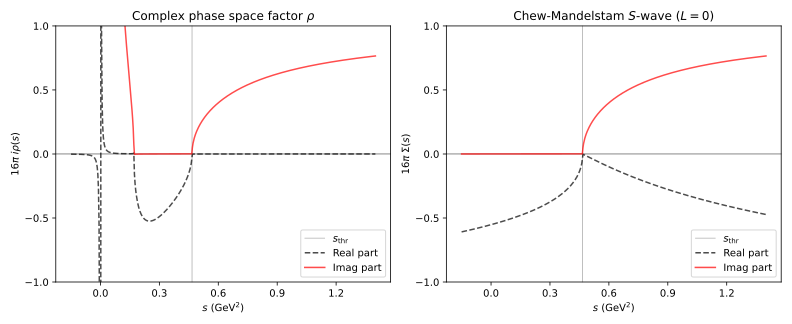

In [ ]:
if STATIC_WEB_PAGE:
    from IPython.display import SVG

    output_file = "chew-mandelstam-s-wave.svg"
    plt.savefig(output_file)
    display(SVG(output_file))

## General dispersion integral

For higher angular momenta, the PDG notes that one has to compute the dispersion integral given by Eq. (49.36) on {pdg-review}`2020; Resonances; p.9`:

$$
\Sigma_a(s+0i) =
    \frac{s-s_{\mathrm{thr}_a}}{\pi}
    \int^\infty_{s_{\mathrm{thr}_a}} \frac{
        \rho_a(s')n_a^2(s')
    }{
        (s' - s_{\mathrm{thr}_a})(s'-s-i0)
    }
    \mathop{}\!\mathrm{d}s'
$$ (integrand)

From {pdg-review}`2020; Resonances; p.6`, right after Eq. (49.19), it can be deduced that the function $n_a^2$ is the same as AmpForm's {class}`~ampform.dynamics.BlattWeisskopfSquared` (note that this function is normalized, whereas the PDG's $F_j$ function has $1$ in the nominator). Furthermore, the PDG seems to suggest that $z = q_a/q_0$, but this is an unconventional choice and is probably a mistake. For this reason, we simply use {class}`~ampform.dynamics.BlattWeisskopfSquared` for the definition of $n_a^2$:

In [ ]:
def na2(s, m1, m2, L, q0):
    q_squared = breakup_momentum_squared(s, m1, m2)
    return BlattWeisskopfSquared(
        z=q_squared / (q0 ** 2),
        angular_momentum=L,
    )

For $\rho_a$, we use AmpForm's {class}`~ampform.dynamics.PhaseSpaceFactor`:

In [ ]:
q0 = sp.Symbol("q0", real=True)
L = sp.Symbol("L", integer=True, positive=True)
s_thr = (m1 + m2) ** 2
integrand = (
    phase_space_factor(s_prime, m1, m2) * na2(s_prime, m1, m2, L, q0)
) / ((s_prime - s_thr) * (s_prime - s - epsilon * sp.I))

In [ ]:
integrand_subs = integrand.subs(
    {
        2
        * breakup_momentum_squared(s_prime, m1, m2): 2
        * sp.Symbol("q_a^{2}"),
        phase_space_factor(s_prime, m1, m2): sp.Symbol(R"\rho_a(s^{\prime})"),
        s_thr: sp.Symbol(R"s_\mathrm{thr}"),
    }
)
display(
    integrand_subs,
    Math(f"= {sp.latex(integrand)}"),
)

\rho_a(s^{\prime})*BlattWeisskopfSquared(L, q_a^{2}/q0**2)/((s^{\prime} - s_\mathrm{thr})*(-I*epsilon - s + s^{\prime}))

<IPython.core.display.Math object>

Next, we {func}`~sympy.utilities.lambdify.lambdify` this integrand to a {mod}`numpy` expression so that we can integrate it with {mod}`scipy.integrate`:

In [ ]:
np_integrand = sp.lambdify(
    args=(s, s_prime, L, epsilon, m1, m2, q0),
    expr=integrand.doit(),
    modules="numpy",
)

We integrate the integrand over $s'$ with {func}`scipy.integrate.quad`. We want to do this for any value of $s$, so we have to wrap it in a function. When, in addition, we decorate this function with {obj}`numpy.vectorize`, the resulting function can handle {obj}`numpy.array`s.

Note that a small trick had to be applied here to handle complex values. The {func}`scipy.integrate.quad` function cannot handle complex values, because it uses Fortran as a back-end (see e.g. [here](https://stackoverflow.com/a/5966088/13219025)).

In [ ]:
s_thr_val = float(s_thr.subs({m1: m1_val, m2: m2_val}))


def integral(s, L, epsilon, m1, m2, q0):
    values_real, errors_real = scipy.integrate.quad(
        lambda s_prime: np_integrand(s, s_prime, L, epsilon, m1, m2, q0).real,
        a=s_thr_val,
        b=np.inf,
    )
    values_imag, errors_imag = scipy.integrate.quad(
        lambda s_prime: np_integrand(s, s_prime, L, epsilon, m1, m2, q0).imag,
        a=s_thr_val,
        b=np.inf,
    )
    return values_real + values_imag * 1j


np_integral = np.vectorize(integral)

Now, for comparison, we compute this integral for a few values of $L>0$:

In [ ]:
s_domain = np.linspace(s_min, s_max, num=50)
max_L = 3
l_values = list(range(1, max_L + 1))
print("Computing for L ∈", l_values)

Computing for L ∈ [1, 2, 3]


It is handy to store the resulting values of each dispersion integral in a {obj}`dict` with $L$ as keys:

In [ ]:
%%time
integral_values = {
    L: np_integral(
        s_domain,
        L=L,
        epsilon=1e-3,
        m1=m1_val,
        m2=m2_val,
        q0=1.0,
    )
    for L in l_values
}

CPU times: user 7.77 s, sys: 0 ns, total: 7.77 s
Wall time: 7.77 s


Finally, as can be seen from Eq. {eq}`integrand`, the resulting values from the integral have to be shifted with a factor $\frac{s-s_{\mathrm{thr}_a}}{\pi}$ to get $\Sigma_a$. We also scale the values with $16\pi$ so that it can be compared with the plot generated in {ref}`report/003:S-wave`.

In [ ]:
sigma = {
    L: (s_domain - s_thr_val) / np.pi * integral_values[L] for L in l_values
}
sigma_scaled = {L: 16 * np.pi * sigma[L] for L in l_values}

In [ ]:
fig, axes = plt.subplots(
    nrows=len(l_values),
    sharex=True,
    figsize=(5, 2.5 * len(l_values)),
    tight_layout=True,
)
fig.suptitle(f"Dispersion integrals for $m_1={m1_val:.2f}, m_2={m2_val:.2f}$")
for ax, L in zip(axes, l_values):
    ax.axhline(0, linewidth=0.5, c="black")
    ax.axvline(s_thr_val, c="grey", linewidth=0.5, label=R"$s_\mathrm{thr}$")
    ax.plot(
        s_domain,
        sigma_scaled[L].real,
        c="black",
        linestyle="dashed",
        label="Real part",
    )
    ax.plot(
        s_domain,
        sigma_scaled[L].imag,
        c="red",
        label="Imag part",
    )
    ax.set_title(f"$L = {L}$")
    ax.set_ylabel(R"$16\pi \; \Sigma(s)$")
axes[-1].set_xlabel("$s$ (GeV$^2$)")
axes[0].legend()
plt.show()

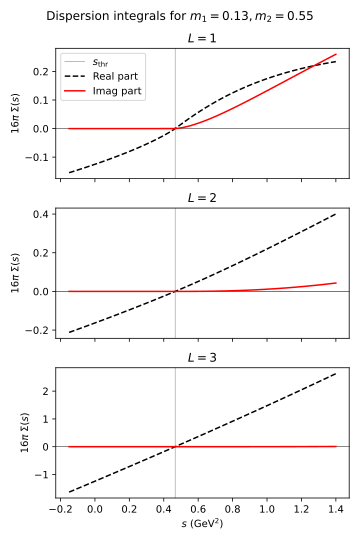

In [ ]:
if STATIC_WEB_PAGE:
    from IPython.display import SVG

    output_file = "chew-mandelstam-l-non-zero.svg"
    plt.savefig(output_file)
    display(SVG(output_file))